## ***Install and Import Libraries***

In [1]:
!pip install -q xgboost lightgbm catboost imbalanced-learn

In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import sys
import kagglehub
import pickle

# Preprocessing & Feature Engineering
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif, RFE

# Machine Learning Models
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, VotingClassifier, StackingClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek, SMOTEENN

# Metrics & Evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc, mean_absolute_error, r2_score, matthews_corrcoef, cohen_kappa_score, log_loss, precision_recall_curve, average_precision_score

## ***Config***

In [3]:
# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [4]:
# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (20, 15)
plt.rcParams['font.size'] = 12
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300

## ***Data Loading***

In [5]:
# Load the dataset
path = kagglehub.dataset_download("mathchi/churn-for-bank-customers")
print(f"Path to dataset files: {path}")

# Find the CSV file in the downloaded path
import os
csv_files = [f for f in os.listdir(path) if f.endswith('.csv')]
if csv_files:
    csv_path = os.path.join(path, csv_files[0])
    df = pd.read_csv(csv_path)
    print(f"Loaded dataset from: {csv_path}")
else:
    raise FileNotFoundError("No CSV file found in the downloaded dataset")

print(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns")

Path to dataset files: /kaggle/input/datasets/mathchi/churn-for-bank-customers
Loaded dataset from: /kaggle/input/datasets/mathchi/churn-for-bank-customers/churn.csv
Shape: 10000 rows × 14 columns


In [6]:
# Display first few rows
print(df.head())

   RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         790

In [7]:
# Check data types
print(df.dtypes)

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object


In [8]:
# Check for missing values
missing_count = df.isnull().sum().sum()
if missing_count == 0:
    print("No missing values found")
else:
    print(df.isnull().sum())

No missing values found


In [9]:
# Check for duplicates
duplicate_count = df.duplicated().sum()
print(f"Duplicate rows: {duplicate_count}")
if duplicate_count > 0:
    df = df.drop_duplicates()
    print(f"Removed {duplicate_count} duplicate rows")

Duplicate rows: 0


In [10]:
# Dataset shape
print(f"Dataset Shape")
print(f"Total samples: {df.shape[0]}")
print(f"Total features: {df.shape[1]}")

Dataset Shape
Total samples: 10000
Total features: 14


## ***Data Preprocessing***

In [11]:
# Drop unnecessary columns
columns_to_drop = ['RowNumber', 'CustomerId', 'Surname']
df = df.drop(columns_to_drop, axis=1)
print(f"Dropped columns: {columns_to_drop}")

Dropped columns: ['RowNumber', 'CustomerId', 'Surname']


In [12]:
# Rename target column
df.rename(columns={'Exited': 'Churn'}, inplace=True)
print("Renamed 'Exited' to 'Churn'")

Renamed 'Exited' to 'Churn'


In [13]:
# Display descriptive statistics
print(df.describe())

        CreditScore           Age        Tenure        Balance  NumOfProducts  \
count  10000.000000  10000.000000  10000.000000   10000.000000   10000.000000   
mean     650.528800     38.921800      5.012800   76485.889288       1.530200   
std       96.653299     10.487806      2.892174   62397.405202       0.581654   
min      350.000000     18.000000      0.000000       0.000000       1.000000   
25%      584.000000     32.000000      3.000000       0.000000       1.000000   
50%      652.000000     37.000000      5.000000   97198.540000       1.000000   
75%      718.000000     44.000000      7.000000  127644.240000       2.000000   
max      850.000000     92.000000     10.000000  250898.090000       4.000000   

         HasCrCard  IsActiveMember  EstimatedSalary         Churn  
count  10000.00000    10000.000000     10000.000000  10000.000000  
mean       0.70550        0.515100    100090.239881      0.203700  
std        0.45584        0.499797     57510.492818      0.402769 

In [14]:
# Check target variable distribution
churn_counts = df['Churn'].value_counts()
print(churn_counts)
print(f"Class Distribution:")
print(f"Retained (0): {churn_counts[0]} ({churn_counts[0]/len(df)*100:.2f}%)")
print(f"Churned (1):  {churn_counts[1]} ({churn_counts[1]/len(df)*100:.2f}%)")
print(f"Imbalance Ratio: {churn_counts[0]/churn_counts[1]:.2f}:1")

Churn
0    7963
1    2037
Name: count, dtype: int64
Class Distribution:
Retained (0): 7963 (79.63%)
Churned (1):  2037 (20.37%)
Imbalance Ratio: 3.91:1


## ***Exploratory Data Analysis***

In [15]:
# Churn by Geography
print("Churn by Geography")
geography_churn = pd.crosstab(df['Geography'], df['Churn'], margins=True)
print(geography_churn)

Churn by Geography
Churn         0     1    All
Geography                   
France     4204   810   5014
Germany    1695   814   2509
Spain      2064   413   2477
All        7963  2037  10000


In [16]:
# Churn by Gender
print("Churn by Gender")
gender_churn = pd.crosstab(df['Gender'], df['Churn'], margins=True)
print(gender_churn)

Churn by Gender
Churn      0     1    All
Gender                   
Female  3404  1139   4543
Male    4559   898   5457
All     7963  2037  10000


In [17]:
# Churn by NumOfProducts
print("Churn by Number of Products")
products_churn = pd.crosstab(df['NumOfProducts'], df['Churn'], margins=True)
print(products_churn)

Churn by Number of Products
Churn             0     1    All
NumOfProducts                   
1              3675  1409   5084
2              4242   348   4590
3                46   220    266
4                 0    60     60
All            7963  2037  10000


In [18]:
# Correlation analysis
print("\Correlation with Churn")
numerical_cols = df.select_dtypes(include=[np.number]).columns
correlations = df[numerical_cols].corr()['Churn'].sort_values(ascending=False)
print(correlations)

\Correlation with Churn
Churn              1.000000
Age                0.285323
Balance            0.118533
EstimatedSalary    0.012097
HasCrCard         -0.007138
Tenure            -0.014001
CreditScore       -0.027094
NumOfProducts     -0.047820
IsActiveMember    -0.156128
Name: Churn, dtype: float64


In [19]:
# Create comprehensive EDA visualizations
print("Creating EDA Visualizations")
fig = plt.figure(figsize=(20, 15))

Creating EDA Visualizations


<Figure size 2000x1500 with 0 Axes>

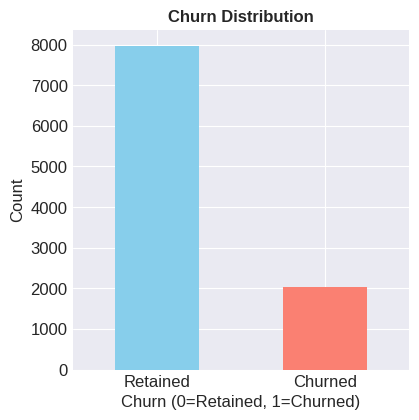

In [20]:
# Churn Distribution
ax1 = plt.subplot(3, 4, 1)
df['Churn'].value_counts().plot(kind='bar', ax=ax1, color=['skyblue', 'salmon'])
ax1.set_title('Churn Distribution', fontweight='bold', fontsize=12)
ax1.set_xlabel('Churn (0=Retained, 1=Churned)')
ax1.set_ylabel('Count')
ax1.set_xticklabels(['Retained', 'Churned'], rotation=0)
plt.show()

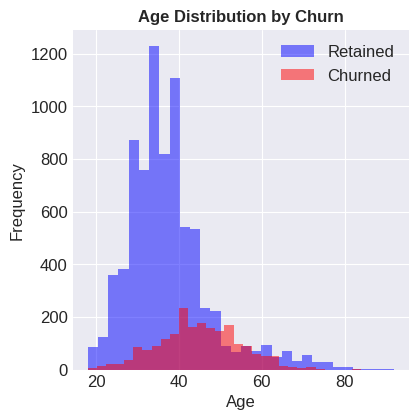

In [21]:
# Age Distribution by Churn
ax2 = plt.subplot(3, 4, 2)
df[df['Churn'] == 0]['Age'].hist(bins=30, alpha=0.5, label='Retained', ax=ax2, color='blue')
df[df['Churn'] == 1]['Age'].hist(bins=30, alpha=0.5, label='Churned', ax=ax2, color='red')
ax2.set_title('Age Distribution by Churn', fontweight='bold', fontsize=12)
ax2.set_xlabel('Age')
ax2.set_ylabel('Frequency')
ax2.legend()
plt.show()

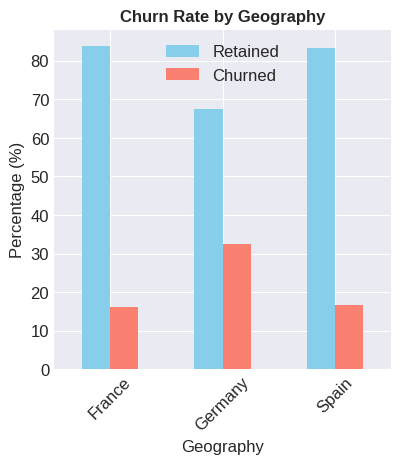

In [22]:
# Churn by Geography
ax3 = plt.subplot(3, 4, 3)
geography_churn_pct = pd.crosstab(df['Geography'], df['Churn'], normalize='index') * 100
geography_churn_pct.plot(kind='bar', ax=ax3, stacked=False, color=['skyblue', 'salmon'])
ax3.set_title('Churn Rate by Geography', fontweight='bold', fontsize=12)
ax3.set_xlabel('Geography')
ax3.set_ylabel('Percentage (%)')
ax3.legend(['Retained', 'Churned'])
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45)
plt.show()

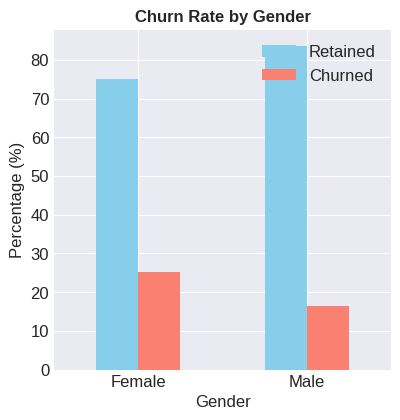

In [23]:
# Churn by Gender
ax4 = plt.subplot(3, 4, 4)
gender_churn_pct = pd.crosstab(df['Gender'], df['Churn'], normalize='index') * 100
gender_churn_pct.plot(kind='bar', ax=ax4, stacked=False, color=['skyblue', 'salmon'])
ax4.set_title('Churn Rate by Gender', fontweight='bold', fontsize=12)
ax4.set_xlabel('Gender')
ax4.set_ylabel('Percentage (%)')
ax4.legend(['Retained', 'Churned'])
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=0)
plt.show()

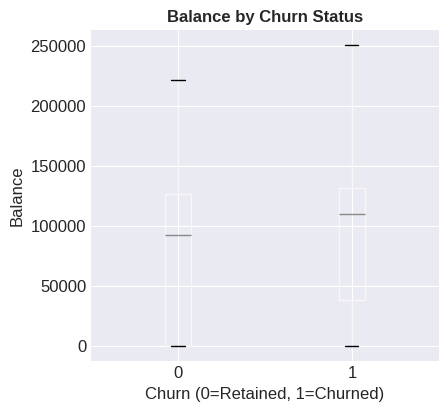

In [24]:
# Balance Distribution
ax5 = plt.subplot(3, 4, 5)
df.boxplot(column='Balance', by='Churn', ax=ax5)
ax5.set_title('Balance by Churn Status', fontweight='bold', fontsize=12)
ax5.set_xlabel('Churn (0=Retained, 1=Churned)')
ax5.set_ylabel('Balance')
plt.suptitle('')
plt.show()

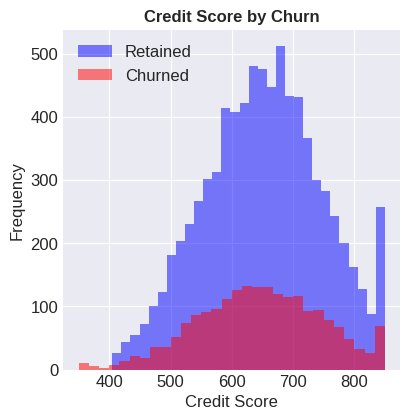

In [25]:
# Credit Score Distribution
ax6 = plt.subplot(3, 4, 6)
df[df['Churn'] == 0]['CreditScore'].hist(bins=30, alpha=0.5, label='Retained', ax=ax6, color='blue')
df[df['Churn'] == 1]['CreditScore'].hist(bins=30, alpha=0.5, label='Churned', ax=ax6, color='red')
ax6.set_title('Credit Score by Churn', fontweight='bold', fontsize=12)
ax6.set_xlabel('Credit Score')
ax6.set_ylabel('Frequency')
ax6.legend()
plt.show()

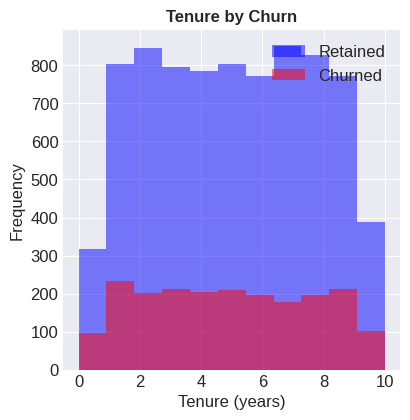

In [26]:
# Tenure Distribution
ax7 = plt.subplot(3, 4, 7)
df[df['Churn'] == 0]['Tenure'].hist(bins=11, alpha=0.5, label='Retained', ax=ax7, color='blue')
df[df['Churn'] == 1]['Tenure'].hist(bins=11, alpha=0.5, label='Churned', ax=ax7, color='red')
ax7.set_title('Tenure by Churn', fontweight='bold', fontsize=12)
ax7.set_xlabel('Tenure (years)')
ax7.set_ylabel('Frequency')
ax7.legend()
plt.show()

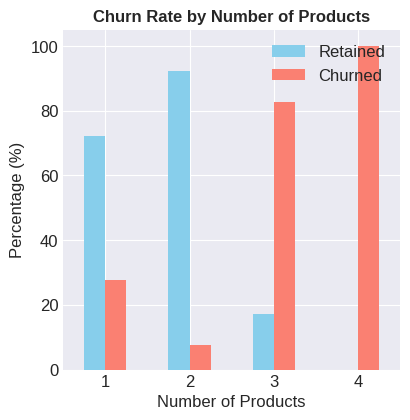

In [27]:
# Number of Products
ax8 = plt.subplot(3, 4, 8)
products_churn_pct = pd.crosstab(df['NumOfProducts'], df['Churn'], normalize='index') * 100
products_churn_pct.plot(kind='bar', ax=ax8, stacked=False, color=['skyblue', 'salmon'])
ax8.set_title('Churn Rate by Number of Products', fontweight='bold', fontsize=12)
ax8.set_xlabel('Number of Products')
ax8.set_ylabel('Percentage (%)')
ax8.legend(['Retained', 'Churned'])
ax8.set_xticklabels(ax8.get_xticklabels(), rotation=0)
plt.show()

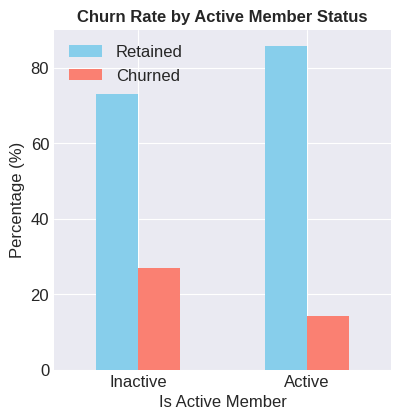

In [28]:
# Active Member Status
ax9 = plt.subplot(3, 4, 9)
active_churn_pct = pd.crosstab(df['IsActiveMember'], df['Churn'], normalize='index') * 100
active_churn_pct.plot(kind='bar', ax=ax9, stacked=False, color=['skyblue', 'salmon'])
ax9.set_title('Churn Rate by Active Member Status', fontweight='bold', fontsize=12)
ax9.set_xlabel('Is Active Member')
ax9.set_ylabel('Percentage (%)')
ax9.legend(['Retained', 'Churned'])
ax9.set_xticklabels(['Inactive', 'Active'], rotation=0)
plt.show()

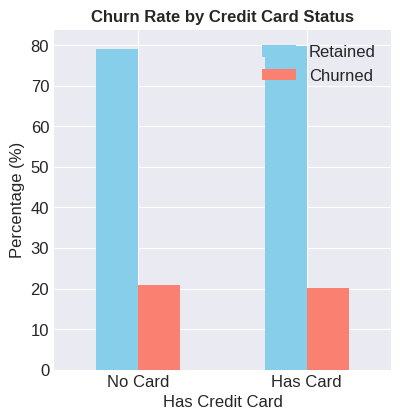

In [29]:
# Credit Card Status
ax10 = plt.subplot(3, 4, 10)
card_churn_pct = pd.crosstab(df['HasCrCard'], df['Churn'], normalize='index') * 100
card_churn_pct.plot(kind='bar', ax=ax10, stacked=False, color=['skyblue', 'salmon'])
ax10.set_title('Churn Rate by Credit Card Status', fontweight='bold', fontsize=12)
ax10.set_xlabel('Has Credit Card')
ax10.set_ylabel('Percentage (%)')
ax10.legend(['Retained', 'Churned'])
ax10.set_xticklabels(['No Card', 'Has Card'], rotation=0)
plt.show()

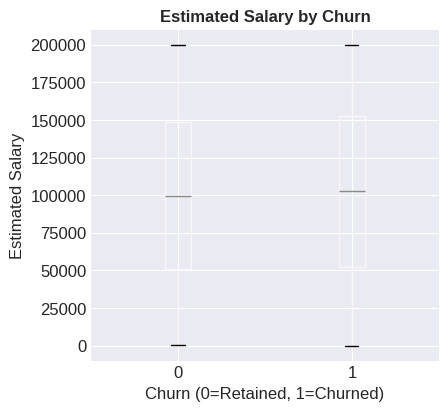

In [30]:
# Estimated Salary Distribution
ax11 = plt.subplot(3, 4, 11)
df.boxplot(column='EstimatedSalary', by='Churn', ax=ax11)
ax11.set_title('Estimated Salary by Churn', fontweight='bold', fontsize=12)
ax11.set_xlabel('Churn (0=Retained, 1=Churned)')
ax11.set_ylabel('Estimated Salary')
plt.suptitle('')
plt.show()

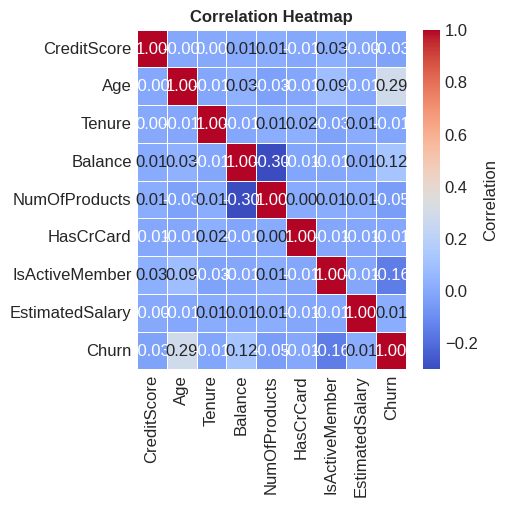

In [31]:
# 12. Correlation Heatmap
ax12 = plt.subplot(3, 4, 12)
correlation_matrix = df[numerical_cols].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', ax=ax12, 
            cbar_kws={'label': 'Correlation'}, linewidths=0.5)
ax12.set_title('Correlation Heatmap', fontweight='bold', fontsize=12)
plt.show()

In [32]:
plt.tight_layout()
plt.savefig('eda_comprehensive_analysis.png', dpi=300, bbox_inches='tight')
print("EDA visualizations saved as 'eda_comprehensive_analysis.png'")
plt.close()

EDA visualizations saved as 'eda_comprehensive_analysis.png'


## ***Feature Engineering***

In [33]:
# Create a copy for feature engineering
df_engineered = df.copy()

In [34]:
# Creating New Features
# Age Groups
df_engineered['AgeGroup'] = pd.cut(df_engineered['Age'], 
                                    bins=[0, 30, 40, 50, 60, 100], 
                                    labels=[1, 2, 3, 4, 5])  # Using numeric labels
df_engineered['AgeGroup'] = df_engineered['AgeGroup'].astype(int)

In [35]:
# Balance Groups
df_engineered['BalanceGroup'] = pd.cut(df_engineered['Balance'], 
                                       bins=[-0.01, 0.01, 50000, 100000, 150000, 300000], 
                                       labels=[0, 1, 2, 3, 4])
df_engineered['BalanceGroup'] = df_engineered['BalanceGroup'].astype(int)

In [36]:
# Credit Score Categories
df_engineered['CreditScoreCategory'] = pd.cut(df_engineered['CreditScore'], 
                                               bins=[0, 580, 670, 740, 800, 900], 
                                               labels=[1, 2, 3, 4, 5])
df_engineered['CreditScoreCategory'] = df_engineered['CreditScoreCategory'].astype(int)

In [37]:
# Tenure Groups
df_engineered['TenureGroup'] = pd.cut(df_engineered['Tenure'], 
                                      bins=[-0.01, 2, 5, 10, 15], 
                                      labels=[1, 2, 3, 4])
df_engineered['TenureGroup'] = df_engineered['TenureGroup'].astype(int)

In [38]:
# Balance to Salary Ratio
df_engineered['BalanceToSalaryRatio'] = np.where(
    df_engineered['EstimatedSalary'] > 0,
    df_engineered['Balance'] / df_engineered['EstimatedSalary'],
    0
)

In [39]:
# Products per Tenure Year
df_engineered['ProductsPerTenure'] = np.where(
    df_engineered['Tenure'] > 0,
    df_engineered['NumOfProducts'] / df_engineered['Tenure'],
    df_engineered['NumOfProducts']
)

In [40]:
# Is Senior (Age > 60)
df_engineered['IsSenior'] = (df_engineered['Age'] > 60).astype(int)

In [41]:
# Has Zero Balance
df_engineered['HasZeroBalance'] = (df_engineered['Balance'] == 0).astype(int)

In [42]:
# Active with Card
df_engineered['ActiveWithCard'] = df_engineered['IsActiveMember'] * df_engineered['HasCrCard']

In [43]:
# Engagement Score
df_engineered['EngagementScore'] = (
    df_engineered['IsActiveMember'] * 0.4 +
    df_engineered['HasCrCard'] * 0.2 +
    (df_engineered['NumOfProducts'] / 4) * 0.4
)

In [44]:
# Customer Value Score (Balance + Salary normalized)
df_engineered['CustomerValueScore'] = (
    (df_engineered['Balance'] - df_engineered['Balance'].min()) / 
    (df_engineered['Balance'].max() - df_engineered['Balance'].min()) * 0.5 +
    (df_engineered['EstimatedSalary'] - df_engineered['EstimatedSalary'].min()) / 
    (df_engineered['EstimatedSalary'].max() - df_engineered['EstimatedSalary'].min()) * 0.5
)

In [45]:
# Activity Score
df_engineered['ActivityScore'] = (
    df_engineered['IsActiveMember'] * 0.5 +
    (df_engineered['Tenure'] / 10) * 0.3 +
    (df_engineered['NumOfProducts'] / 4) * 0.2
)

In [46]:
# Credit to Age Ratio
df_engineered['CreditToAgeRatio'] = df_engineered['CreditScore'] / df_engineered['Age']

In [47]:
# Is High Value Customer
df_engineered['IsHighValueCustomer'] = (
    ((df_engineered['Balance'] > df_engineered['Balance'].quantile(0.75)) & 
     (df_engineered['EstimatedSalary'] > df_engineered['EstimatedSalary'].quantile(0.75)))
).astype(int)

In [48]:
# Has Multiple Products
df_engineered['HasMultipleProducts'] = (df_engineered['NumOfProducts'] > 1).astype(int)

In [49]:
# Encode categorical variables
label_encoder_geography = LabelEncoder()
label_encoder_gender = LabelEncoder()

df_engineered['Geography'] = label_encoder_geography.fit_transform(df_engineered['Geography'])
df_engineered['Gender'] = label_encoder_gender.fit_transform(df_engineered['Gender'])

print(f"Encoded Geography: {dict(enumerate(label_encoder_geography.classes_))}")
print(f"Encoded Gender: {dict(enumerate(label_encoder_gender.classes_))}")

Encoded Geography: {0: 'France', 1: 'Germany', 2: 'Spain'}
Encoded Gender: {0: 'Female', 1: 'Male'}


In [50]:
print(f"Final Feature Set")
print(f"Total features: {df_engineered.shape[1] - 1}")  # -1 for target variable
print(f"Feature names: {[col for col in df_engineered.columns if col != 'Churn']}")

Final Feature Set
Total features: 25
Feature names: ['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'AgeGroup', 'BalanceGroup', 'CreditScoreCategory', 'TenureGroup', 'BalanceToSalaryRatio', 'ProductsPerTenure', 'IsSenior', 'HasZeroBalance', 'ActiveWithCard', 'EngagementScore', 'CustomerValueScore', 'ActivityScore', 'CreditToAgeRatio', 'IsHighValueCustomer', 'HasMultipleProducts']


## ***Data Splitting and Preparation***

In [51]:
# Separate features and target
X = df_engineered.drop('Churn', axis=1)
y = df_engineered['Churn']

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

Feature matrix shape: (10000, 25)
Target vector shape: (10000,)


In [52]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples ({(len(X_train)/len(X))*100:.1f}%)")
print(f"Test set: {X_test.shape[0]} samples ({(len(X_test)/len(X))*100:.1f}%)")
print(f"Training churn rate: {y_train.mean()*100:.2f}%")
print(f"Test churn rate: {y_test.mean()*100:.2f}%")

Training set: 7000 samples (70.0%)
Test set: 3000 samples (30.0%)
Training churn rate: 20.37%
Test churn rate: 20.37%


In [53]:
# Handle class imbalance
print(f"Before balancing - Training set class distribution:")
print(f"Class 0 (Retained): {(y_train == 0).sum()}")
print(f"Class 1 (Churned): {(y_train == 1).sum()}")

Before balancing - Training set class distribution:
Class 0 (Retained): 5574
Class 1 (Churned): 1426


In [54]:
smote_tomek = SMOTETomek(random_state=RANDOM_STATE)
X_train_balanced, y_train_balanced = smote_tomek.fit_resample(X_train, y_train)
    
print(f"\nAfter SMOTE-Tomek - Training set class distribution:")
print(f"Class 0 (Retained): {(y_train_balanced == 0).sum()}")
print(f"Class 1 (Churned): {(y_train_balanced == 1).sum()}")
print(f"Balanced training samples: {len(X_train_balanced)}")


After SMOTE-Tomek - Training set class distribution:
Class 0 (Retained): 4750
Class 1 (Churned): 4750
Balanced training samples: 9500


In [55]:
# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

print(f"Training set shape after scaling: {X_train_scaled.shape}")
print(f"Test set shape after scaling: {X_test_scaled.shape}")

Training set shape after scaling: (9500, 25)
Test set shape after scaling: (3000, 25)


## ***Model Training***

In [56]:
# Dictionary to store model results
model_results = {}
trained_models = {}

### ***Logistic Regression***

In [57]:
lr_params = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'liblinear'],
    'max_iter': [1000]
}

In [58]:
lr = LogisticRegression(random_state=RANDOM_STATE)
lr_grid = GridSearchCV(lr, lr_params, cv=5, scoring='roc_auc', n_jobs=-1, verbose=0)
lr_grid.fit(X_train_scaled, y_train_balanced)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'max_iter': [1000], 'penalty': ['l2'],
                         'solver': ['lbfgs', 'liblinear']},
             scoring='roc_auc')

In [59]:
lr_best = lr_grid.best_estimator_
lr_pred = lr_best.predict(X_test_scaled)
lr_pred_proba = lr_best.predict_proba(X_test_scaled)[:, 1]

In [60]:
model_results['Logistic Regression'] = {
    'accuracy': accuracy_score(y_test, lr_pred),
    'precision': precision_score(y_test, lr_pred),
    'recall': recall_score(y_test, lr_pred),
    'f1_score': f1_score(y_test, lr_pred),
    'roc_auc': roc_auc_score(y_test, lr_pred_proba),
    'best_params': lr_grid.best_params_
}
trained_models['Logistic Regression'] = lr_best

In [61]:
print(f"Best params: {lr_grid.best_params_}")
print(f"Accuracy: {model_results['Logistic Regression']['accuracy']:.4f}")
print(f"ROC-AUC: {model_results['Logistic Regression']['roc_auc']:.4f}")

Best params: {'C': 100, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}
Accuracy: 0.8523
ROC-AUC: 0.8534


### ***Decision Trees***

In [62]:
dt_params = {
    'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'criterion': ['gini', 'entropy'],
    'random_state': [0, 42]
}

In [63]:
dtree = DecisionTreeClassifier()
dt_grid = GridSearchCV(dtree, dt_params, cv=5, scoring='roc_auc', n_jobs=-1, verbose=0)
dt_grid.fit(X_train_scaled, y_train_balanced)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'random_state': [0, 42]},
             scoring='roc_auc')

In [64]:
dtree_best = dt_grid.best_estimator_
dtree_pred = dtree_best.predict(X_test_scaled)
dtree_pred_proba = dtree_best.predict_proba(X_test_scaled)[:, 1]

In [65]:
model_results['Decision Tree'] = {
    'accuracy': accuracy_score(y_test, dtree_pred),
    'precision': precision_score(y_test, dtree_pred),
    'recall': recall_score(y_test, dtree_pred),
    'f1_score': f1_score(y_test, dtree_pred),
    'roc_auc': roc_auc_score(y_test, dtree_pred_proba),
    'best_params': dt_grid.best_params_
}
trained_models['Decision Tree'] = dtree_best

In [66]:
print(f"Best params: {dt_grid.best_params_}")
print(f"Accuracy: {model_results['Decision Tree']['accuracy']:.4f}")
print(f"ROC-AUC: {model_results['Decision Tree']['roc_auc']:.4f}")

Best params: {'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 9, 'random_state': 0}
Accuracy: 0.8317
ROC-AUC: 0.8283


### ***Random Forest***

In [67]:
rf_params = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [2, 5, 7, 9],
    'criterion': ['gini', 'entropy'],
    'min_samples_leaf': [1, 2, 4, 6, 8]
}

In [68]:
rfc = RandomForestClassifier(random_state=RANDOM_STATE)
rf_grid = GridSearchCV(rfc, rf_params, cv=5, scoring='roc_auc', n_jobs=-1, verbose=0)
rf_grid.fit(X_train_scaled, y_train_balanced)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 5, 7, 9],
                         'min_samples_leaf': [1, 2, 4, 6, 8],
                         'n_estimators': [10, 50, 100, 200]},
             scoring='roc_auc')

In [69]:
rfc_best = rf_grid.best_estimator_
rfc_pred = rfc_best.predict(X_test_scaled)
rfc_pred_proba = rfc_best.predict_proba(X_test_scaled)[:, 1]

In [70]:
model_results['Random Forest'] = {
    'accuracy': accuracy_score(y_test, rfc_pred),
    'precision': precision_score(y_test, rfc_pred),
    'recall': recall_score(y_test, rfc_pred),
    'f1_score': f1_score(y_test, rfc_pred),
    'roc_auc': roc_auc_score(y_test, rfc_pred_proba),
    'best_params': rf_grid.best_params_
}
trained_models['Random Forest'] = rfc_best

In [71]:
print(f"Best params: {rf_grid.best_params_}")
print(f"Accuracy: {model_results['Random Forest']['accuracy']:.4f}")
print(f"ROC-AUC: {model_results['Random Forest']['roc_auc']:.4f}")

Best params: {'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 1, 'n_estimators': 200}
Accuracy: 0.8387
ROC-AUC: 0.8608


### ***Gradient Boosting***

In [72]:
gb_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0]
}

In [73]:
gb = GradientBoostingClassifier(random_state=RANDOM_STATE)
gb_grid = GridSearchCV(gb, gb_params, cv=5, scoring='roc_auc', n_jobs=-1, verbose=0)
gb_grid.fit(X_train_scaled, y_train_balanced)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'n_estimators': [50, 100, 200],
                         'subsample': [0.8, 1.0]},
             scoring='roc_auc')

In [74]:
gb_best = gb_grid.best_estimator_
gb_pred = gb_best.predict(X_test_scaled)
gb_pred_proba = gb_best.predict_proba(X_test_scaled)[:, 1]

In [75]:
model_results['Gradient Boosting'] = {
    'accuracy': accuracy_score(y_test, gb_pred),
    'precision': precision_score(y_test, gb_pred),
    'recall': recall_score(y_test, gb_pred),
    'f1_score': f1_score(y_test, gb_pred),
    'roc_auc': roc_auc_score(y_test, gb_pred_proba),
    'best_params': gb_grid.best_params_
}
trained_models['Gradient Boosting'] = gb_best

In [76]:
print(f"Best params: {gb_grid.best_params_}")
print(f"Accuracy: {model_results['Gradient Boosting']['accuracy']:.4f}")
print(f"ROC-AUC: {model_results['Gradient Boosting']['roc_auc']:.4f}")

Best params: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
Accuracy: 0.8470
ROC-AUC: 0.8458


### ***Support Vector Machine(SVM)***

In [77]:
svm_params = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf', 'linear'],
    'gamma': ['scale', 'auto']
}

In [78]:
svm = SVC(probability=True, random_state=RANDOM_STATE)
svm_grid = GridSearchCV(svm, svm_params, cv=5, scoring='roc_auc', n_jobs=-1, verbose=0)
svm_grid.fit(X_train_scaled, y_train_balanced)

GridSearchCV(cv=5, estimator=SVC(probability=True, random_state=42), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'],
                         'kernel': ['rbf', 'linear']},
             scoring='roc_auc')

In [79]:
svm_best = svm_grid.best_estimator_
svm_pred = svm_best.predict(X_test_scaled)
svm_pred_proba = svm_best.predict_proba(X_test_scaled)[:, 1]

In [80]:
model_results['SVM'] = {
    'accuracy': accuracy_score(y_test, svm_pred),
    'precision': precision_score(y_test, svm_pred),
    'recall': recall_score(y_test, svm_pred),
    'f1_score': f1_score(y_test, svm_pred),
    'roc_auc': roc_auc_score(y_test, svm_pred_proba),
    'best_params': svm_grid.best_params_
}
trained_models['SVM'] = svm_best

In [81]:
print(f"Best params: {svm_grid.best_params_}")
print(f"Accuracy: {model_results['SVM']['accuracy']:.4f}")
print(f"ROC-AUC: {model_results['SVM']['roc_auc']:.4f}")

Best params: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Accuracy: 0.8400
ROC-AUC: 0.8151


### ***K-Nearest Neighbours(KNN)***

In [82]:
knn_params = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

In [83]:
knn = KNeighborsClassifier()
knn_grid = GridSearchCV(knn, knn_params, cv=5, scoring='roc_auc', n_jobs=-1, verbose=0)
knn_grid.fit(X_train_scaled, y_train_balanced)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [3, 5, 7, 9, 11],
                         'weights': ['uniform', 'distance']},
             scoring='roc_auc')

In [84]:
knn_best = knn_grid.best_estimator_
knn_pred = knn_best.predict(X_test_scaled)
knn_pred_proba = knn_best.predict_proba(X_test_scaled)[:, 1]

In [85]:
model_results['KNN'] = {
    'accuracy': accuracy_score(y_test, knn_pred),
    'precision': precision_score(y_test, knn_pred),
    'recall': recall_score(y_test, knn_pred),
    'f1_score': f1_score(y_test, knn_pred),
    'roc_auc': roc_auc_score(y_test, knn_pred_proba),
    'best_params': knn_grid.best_params_
}
trained_models['KNN'] = knn_best

In [86]:
print(f"Best params: {knn_grid.best_params_}")
print(f"Accuracy: {model_results['KNN']['accuracy']:.4f}")
print(f"ROC-AUC: {model_results['KNN']['roc_auc']:.4f}")

Best params: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}
Accuracy: 0.8033
ROC-AUC: 0.8175


### ***Naive Bayes Classifier***

In [87]:
nb_params = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}

In [88]:
nb = GaussianNB()
nb_grid = GridSearchCV(nb, nb_params, cv=5, scoring='roc_auc', n_jobs=-1, verbose=0)
nb_grid.fit(X_train_scaled, y_train_balanced)

GridSearchCV(cv=5, estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': [1e-09, 1e-08, 1e-07, 1e-06, 1e-05]},
             scoring='roc_auc')

In [89]:
nb_best = nb_grid.best_estimator_
nb_pred = nb_best.predict(X_test_scaled)
nb_pred_proba = nb_best.predict_proba(X_test_scaled)[:, 1]

In [90]:
model_results['Naive Bayes'] = {
    'accuracy': accuracy_score(y_test, nb_pred),
    'precision': precision_score(y_test, nb_pred),
    'recall': recall_score(y_test, nb_pred),
    'f1_score': f1_score(y_test, nb_pred),
    'roc_auc': roc_auc_score(y_test, nb_pred_proba),
    'best_params': nb_grid.best_params_
}
trained_models['Naive Bayes'] = nb_best

In [91]:
print(f"Best params: {nb_grid.best_params_}")
print(f"Accuracy: {model_results['Naive Bayes']['accuracy']:.4f}")
print(f"ROC-AUC: {model_results['Naive Bayes']['roc_auc']:.4f}")

Best params: {'var_smoothing': 1e-05}
Accuracy: 0.7570
ROC-AUC: 0.7200


### ***AdaBoost***

In [92]:
ada_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5, 1.0]
}

In [93]:
ada = AdaBoostClassifier(random_state=RANDOM_STATE, algorithm='SAMME')
ada_grid = GridSearchCV(ada, ada_params, cv=5, scoring='roc_auc', n_jobs=-1, verbose=0)
ada_grid.fit(X_train_scaled, y_train_balanced)

/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 

GridSearchCV(cv=5,
             estimator=AdaBoostClassifier(algorithm='SAMME', random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.5, 1.0],
                         'n_estimators': [50, 100, 200]},
             scoring='roc_auc')

In [94]:
ada_best = ada_grid.best_estimator_
ada_pred = ada_best.predict(X_test_scaled)
ada_pred_proba = ada_best.predict_proba(X_test_scaled)[:, 1]

In [95]:
model_results['AdaBoost'] = {
    'accuracy': accuracy_score(y_test, ada_pred),
    'precision': precision_score(y_test, ada_pred),
    'recall': recall_score(y_test, ada_pred),
    'f1_score': f1_score(y_test, ada_pred),
    'roc_auc': roc_auc_score(y_test, ada_pred_proba),
    'best_params': ada_grid.best_params_
}
trained_models['AdaBoost'] = ada_best

In [96]:
print(f"Best params: {ada_grid.best_params_}")
print(f"Accuracy: {model_results['AdaBoost']['accuracy']:.4f}")
print(f"ROC-AUC: {model_results['AdaBoost']['roc_auc']:.4f}")

Best params: {'learning_rate': 1.0, 'n_estimators': 200}
Accuracy: 0.8467
ROC-AUC: 0.8639


### ***Extra Trees***

In [97]:
et_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [98]:
et = ExtraTreesClassifier(random_state=RANDOM_STATE)
et_grid = GridSearchCV(et, et_params, cv=5, scoring='roc_auc', n_jobs=-1, verbose=0)
et_grid.fit(X_train_scaled, y_train_balanced)

GridSearchCV(cv=5, estimator=ExtraTreesClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='roc_auc')

In [99]:
et_best = et_grid.best_estimator_
et_pred = et_best.predict(X_test_scaled)
et_pred_proba = et_best.predict_proba(X_test_scaled)[:, 1]

In [100]:
model_results['Extra Trees'] = {
    'accuracy': accuracy_score(y_test, et_pred),
    'precision': precision_score(y_test, et_pred),
    'recall': recall_score(y_test, et_pred),
    'f1_score': f1_score(y_test, et_pred),
    'roc_auc': roc_auc_score(y_test, et_pred_proba),
    'best_params': et_grid.best_params_
}
trained_models['Extra Trees'] = et_best

In [101]:
print(f"Best params: {et_grid.best_params_}")
print(f"Accuracy: {model_results['Extra Trees']['accuracy']:.4f}")
print(f"ROC-AUC: {model_results['Extra Trees']['roc_auc']:.4f}")

Best params: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy: 0.8433
ROC-AUC: 0.8505


### ***Linear Discriminant Analysis***

In [102]:
lda_params = {
    'solver': ['svd', 'lsqr', 'eigen'],
    'shrinkage': [None, 'auto', 0.1, 0.5, 0.9]
}

In [103]:
lda = LinearDiscriminantAnalysis()
lda_grid = GridSearchCV(lda, lda_params, cv=5, scoring='roc_auc', n_jobs=-1, verbose=0)
lda_grid.fit(X_train_scaled, y_train_balanced)

GridSearchCV(cv=5, estimator=LinearDiscriminantAnalysis(), n_jobs=-1,
             param_grid={'shrinkage': [None, 'auto', 0.1, 0.5, 0.9],
                         'solver': ['svd', 'lsqr', 'eigen']},
             scoring='roc_auc')

In [104]:
lda_best = lda_grid.best_estimator_
lda_pred = lda_best.predict(X_test_scaled)
lda_pred_proba = lda_best.predict_proba(X_test_scaled)[:, 1]

In [105]:
model_results['LDA'] = {
    'accuracy': accuracy_score(y_test, lda_pred),
    'precision': precision_score(y_test, lda_pred),
    'recall': recall_score(y_test, lda_pred),
    'f1_score': f1_score(y_test, lda_pred),
    'roc_auc': roc_auc_score(y_test, lda_pred_proba),
    'best_params': lda_grid.best_params_
}
trained_models['LDA'] = lda_best

In [106]:
print(f"Best params: {lda_grid.best_params_}")
print(f"Accuracy: {model_results['LDA']['accuracy']:.4f}")
print(f"ROC-AUC: {model_results['LDA']['roc_auc']:.4f}")

Best params: {'shrinkage': None, 'solver': 'svd'}
Accuracy: 0.8240
ROC-AUC: 0.8201


### ***Quadratic Discriminant Analysis***

In [107]:
qda_params = {
    'reg_param': [0.0, 0.1, 0.2, 0.3, 0.5, 0.7, 0.9]
}

In [108]:
qda = QuadraticDiscriminantAnalysis()
qda_grid = GridSearchCV(qda, qda_params, cv=5, scoring='roc_auc', n_jobs=-1, verbose=0)
qda_grid.fit(X_train_scaled, y_train_balanced)

/usr/local/lib/python3.12/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

GridSearchCV(cv=5, estimator=QuadraticDiscriminantAnalysis(), n_jobs=-1,
             param_grid={'reg_param': [0.0, 0.1, 0.2, 0.3, 0.5, 0.7, 0.9]},
             scoring='roc_auc')

In [109]:
qda_best = qda_grid.best_estimator_
qda_pred = qda_best.predict(X_test_scaled)
qda_pred_proba = qda_best.predict_proba(X_test_scaled)[:, 1]

In [110]:
model_results['QDA'] = {
    'accuracy': accuracy_score(y_test, qda_pred),
    'precision': precision_score(y_test, qda_pred),
    'recall': recall_score(y_test, qda_pred),
    'f1_score': f1_score(y_test, qda_pred),
    'roc_auc': roc_auc_score(y_test, qda_pred_proba),
    'best_params': qda_grid.best_params_
}
trained_models['QDA'] = qda_best

In [111]:
print(f"Best params: {qda_grid.best_params_}")
print(f"Accuracy: {model_results['QDA']['accuracy']:.4f}")
print(f"ROC-AUC: {model_results['QDA']['roc_auc']:.4f}")

Best params: {'reg_param': 0.0}
Accuracy: 0.8183
ROC-AUC: 0.7472


### ***XGBoost***

In [112]:
xgb_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

In [113]:
xgb = XGBClassifier(random_state=RANDOM_STATE, eval_metric='logloss', use_label_encoder=False)
xgb_grid = GridSearchCV(xgb, xgb_params, cv=5, scoring='roc_auc', n_jobs=-1, verbose=0)
xgb_grid.fit(X_train_scaled, y_train_balanced)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [04:36:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [04:36:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [04:36:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [04:36:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [04:36:18] WARNING: /w

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraint...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'n_estimators': [100, 200],
                         'subsample': [0.8, 1.0]},
             scoring='roc_auc')

In [114]:
xgb_best = xgb_grid.best_estimator_
xgb_pred = xgb_best.predict(X_test_scaled)
xgb_pred_proba = xgb_best.predict_proba(X_test_scaled)[:, 1]

In [115]:
model_results['XGBoost'] = {
    'accuracy': accuracy_score(y_test, xgb_pred),
    'precision': precision_score(y_test, xgb_pred),
    'recall': recall_score(y_test, xgb_pred),
    'f1_score': f1_score(y_test, xgb_pred),
    'roc_auc': roc_auc_score(y_test, xgb_pred_proba),
    'best_params': xgb_grid.best_params_
}
trained_models['XGBoost'] = xgb_best

In [116]:
print(f"Best params: {xgb_grid.best_params_}")
print(f"Accuracy: {model_results['XGBoost']['accuracy']:.4f}")
print(f"ROC-AUC: {model_results['XGBoost']['roc_auc']:.4f}")

Best params: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
Accuracy: 0.8553
ROC-AUC: 0.8530


### ***LightGBM Classifier***

In [117]:
lgb_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'num_leaves': [31, 50]
}

In [118]:
lgb = LGBMClassifier(random_state=RANDOM_STATE, verbose=-1)
lgb_grid = GridSearchCV(lgb, lgb_params, cv=5, scoring='roc_auc', n_jobs=-1, verbose=0)
lgb_grid.fit(X_train_scaled, y_train_balanced)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ut

GridSearchCV(cv=5, estimator=LGBMClassifier(random_state=42, verbose=-1),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'n_estimators': [100, 200],
                         'num_leaves': [31, 50]},
             scoring='roc_auc')

In [119]:
lgb_best = lgb_grid.best_estimator_
lgb_pred = lgb_best.predict(X_test_scaled)
lgb_pred_proba = lgb_best.predict_proba(X_test_scaled)[:, 1]

In [120]:
model_results['LightGBM'] = {
    'accuracy': accuracy_score(y_test, lgb_pred),
    'precision': precision_score(y_test, lgb_pred),
    'recall': recall_score(y_test, lgb_pred),
    'f1_score': f1_score(y_test, lgb_pred),
    'roc_auc': roc_auc_score(y_test, lgb_pred_proba),
    'best_params': lgb_grid.best_params_
}
trained_models['LightGBM'] = lgb_best

In [121]:
print(f"Best params: {lgb_grid.best_params_}")
print(f"Accuracy: {model_results['LightGBM']['accuracy']:.4f}")
print(f"ROC-AUC: {model_results['LightGBM']['roc_auc']:.4f}")

Best params: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'num_leaves': 50}
Accuracy: 0.8527
ROC-AUC: 0.8385


### ***CatBoost***

In [122]:
cat_params = {
    'iterations': [100, 200],
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1]
}

In [123]:
cat = CatBoostClassifier(random_state=RANDOM_STATE, verbose=0)
cat_grid = GridSearchCV(cat, cat_params, cv=5, scoring='roc_auc', n_jobs=-1, verbose=0)
cat_grid.fit(X_train_scaled, y_train_balanced)

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x7d98865160c0>,
             n_jobs=-1,
             param_grid={'depth': [4, 6, 8], 'iterations': [100, 200],
                         'learning_rate': [0.01, 0.1]},
             scoring='roc_auc')

In [124]:
cat_best = cat_grid.best_estimator_
cat_pred = cat_best.predict(X_test_scaled)
cat_pred_proba = cat_best.predict_proba(X_test_scaled)[:, 1]

In [125]:
model_results['CatBoost'] = {
    'accuracy': accuracy_score(y_test, cat_pred),
    'precision': precision_score(y_test, cat_pred),
    'recall': recall_score(y_test, cat_pred),
    'f1_score': f1_score(y_test, cat_pred),
    'roc_auc': roc_auc_score(y_test, cat_pred_proba),
    'best_params': cat_grid.best_params_
}
trained_models['CatBoost'] = cat_best

In [126]:
print(f"Best params: {cat_grid.best_params_}")
print(f"Accuracy: {model_results['CatBoost']['accuracy']:.4f}")
print(f"ROC-AUC: {model_results['CatBoost']['roc_auc']:.4f}")

Best params: {'depth': 8, 'iterations': 200, 'learning_rate': 0.1}
Accuracy: 0.8613
ROC-AUC: 0.8605


### ***Voting Ensemble***

In [127]:
# Select top 5 models based on ROC-AUC
top_models = sorted(model_results.items(), key=lambda x: x[1]['roc_auc'], reverse=True)[:5]
print(f"Top 5 models selected for ensemble:")
for i, (name, metrics) in enumerate(top_models, 1):
    print(f"{i}. {name}: ROC-AUC = {metrics['roc_auc']:.4f}")

Top 5 models selected for ensemble:
1. AdaBoost: ROC-AUC = 0.8639
2. Random Forest: ROC-AUC = 0.8608
3. CatBoost: ROC-AUC = 0.8605
4. Logistic Regression: ROC-AUC = 0.8534
5. XGBoost: ROC-AUC = 0.8530


In [128]:
# Create voting ensemble
ensemble_estimators = []
for name, _ in top_models:
    ensemble_estimators.append((name, trained_models[name]))

In [129]:
voting_clf = VotingClassifier(estimators=ensemble_estimators, voting='soft', n_jobs=-1)
voting_clf.fit(X_train_scaled, y_train_balanced)

/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [04:39:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


VotingClassifier(estimators=[('AdaBoost',
                              AdaBoostClassifier(algorithm='SAMME',
                                                 n_estimators=200,
                                                 random_state=42)),
                             ('Random Forest',
                              RandomForestClassifier(max_depth=9,
                                                     n_estimators=200,
                                                     random_state=42)),
                             ('CatBoost',
                              <catboost.core.CatBoostClassifier object at 0x7d98865b5520>),
                             ('Logistic Regression',
                              LogisticRegression(C=100, max_iter=1000,
                                                 random_state=42)),
                             ('...
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None, ...))],
                 n_jobs=-1, voting='soft')

In [130]:
voting_pred = voting_clf.predict(X_test_scaled)
voting_pred_proba = voting_clf.predict_proba(X_test_scaled)[:, 1]

In [131]:
model_results['Voting Ensemble'] = {
    'accuracy': accuracy_score(y_test, voting_pred),
    'precision': precision_score(y_test, voting_pred),
    'recall': recall_score(y_test, voting_pred),
    'f1_score': f1_score(y_test, voting_pred),
    'roc_auc': roc_auc_score(y_test, voting_pred_proba),
    'best_params': {'top_5_models': [name for name, _ in top_models]}
}
trained_models['Voting Ensemble'] = voting_clf

In [132]:
print(f"Ensemble Model Performance:")
print(f"Accuracy: {model_results['Voting Ensemble']['accuracy']:.4f}")
print(f"ROC-AUC: {model_results['Voting Ensemble']['roc_auc']:.4f}")

Ensemble Model Performance:
Accuracy: 0.8593
ROC-AUC: 0.8734


## ***Model Comparison and Evaluation***

In [133]:
# Create results DataFrame
results_df = pd.DataFrame(model_results).T
results_df = results_df.round(4)
results_df_sorted = results_df.sort_values('roc_auc', ascending=False)

In [134]:
# Model Performance Summary
print(results_df_sorted[['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']])

                     accuracy precision    recall  f1_score   roc_auc
Voting Ensemble      0.859333  0.707692  0.527005  0.604128  0.873419
AdaBoost             0.846667  0.628183  0.605565  0.616667   0.86389
Random Forest        0.838667  0.609294  0.579378   0.59396   0.86081
CatBoost             0.861333  0.715232  0.530278  0.609023  0.860462
Logistic Regression  0.852333   0.71875  0.451718  0.554774  0.853357
XGBoost              0.855333  0.697105  0.512275  0.590566  0.852958
Extra Trees          0.843333  0.637427  0.535188  0.581851  0.850514
Gradient Boosting       0.847  0.661017  0.510638  0.576177  0.845839
LightGBM             0.852667  0.683297  0.515548  0.587687  0.838513
Decision Tree        0.831667  0.582555  0.612111  0.596967  0.828273
LDA                     0.824  0.577861  0.504092  0.538462  0.820096
KNN                  0.803333  0.516432  0.540098     0.528  0.817502
SVM                      0.84  0.638478  0.494272  0.557196  0.815117
QDA                 

In [135]:
# Identify best model
best_model_name = results_df_sorted['roc_auc'].idxmax()
best_model = trained_models[best_model_name]
best_metrics = model_results[best_model_name]

In [136]:
print(f"BEST MODEL: {best_model_name}".center(100))
print(f"Accuracy:   {best_metrics['accuracy']:.4f} ({best_metrics['accuracy']*100:.2f}%)")
print(f"Precision:  {best_metrics['precision']:.4f} ({best_metrics['precision']*100:.2f}%)")
print(f"Recall:     {best_metrics['recall']:.4f} ({best_metrics['recall']*100:.2f}%)")
print(f"F1-Score:   {best_metrics['f1_score']:.4f}")
print(f"ROC-AUC:    {best_metrics['roc_auc']:.4f}")

                                    BEST MODEL: Voting Ensemble                                     
Accuracy:   0.8593 (85.93%)
Precision:  0.7077 (70.77%)
Recall:     0.5270 (52.70%)
F1-Score:   0.6041
ROC-AUC:    0.8734


In [137]:
# Get predictions from best model
if best_model_name == 'Voting Ensemble':
    best_pred = voting_pred
    best_pred_proba = voting_pred_proba
else:
    best_pred = trained_models[best_model_name].predict(X_test_scaled)
    best_pred_proba = trained_models[best_model_name].predict_proba(X_test_scaled)[:, 1]

In [138]:
# Detailed classification report
print(f"Classification Report for {best_model_name}")
print(classification_report(y_test, best_pred, target_names=['Retained (0)', 'Churned (1)']))

Classification Report for Voting Ensemble
              precision    recall  f1-score   support

Retained (0)       0.89      0.94      0.91      2389
 Churned (1)       0.71      0.53      0.60       611

    accuracy                           0.86      3000
   macro avg       0.80      0.74      0.76      3000
weighted avg       0.85      0.86      0.85      3000



In [139]:
# Confusion Matrix
print(f"Confusion Matrix for {best_model_name}")
cm = confusion_matrix(y_test, best_pred)
print(cm)
print(f"\nTrue Negatives (Correctly predicted Retained):  {cm[0,0]}")
print(f"False Positives (Incorrectly predicted Churned): {cm[0,1]}")
print(f"False Negatives (Incorrectly predicted Retained): {cm[1,0]}")
print(f"True Positives (Correctly predicted Churned):   {cm[1,1]}")

Confusion Matrix for Voting Ensemble
[[2256  133]
 [ 289  322]]

True Negatives (Correctly predicted Retained):  2256
False Positives (Incorrectly predicted Churned): 133
False Negatives (Incorrectly predicted Retained): 289
True Positives (Correctly predicted Churned):   322


In [140]:
# Additional Metrics
print(f"Additional Performance Metrics for {best_model_name}")
print(f"Matthews Correlation Coefficient: {matthews_corrcoef(y_test, best_pred):.4f}")
print(f"Cohen's Kappa Score: {cohen_kappa_score(y_test, best_pred):.4f}")
print(f"Log Loss: {log_loss(y_test, best_pred_proba):.4f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, best_pred):.4f}")
print(f"R2 Score: {r2_score(y_test, best_pred):.4f}")

Additional Performance Metrics for Voting Ensemble
Matthews Correlation Coefficient: 0.5292
Cohen's Kappa Score: 0.5208
Log Loss: 0.3675
Mean Absolute Error: 0.1407
R2 Score: 0.1327


## ***Results Visualizations***

In [141]:
# Create main visualization figure
fig = plt.figure(figsize=(24, 18))

<Figure size 2400x1800 with 0 Axes>

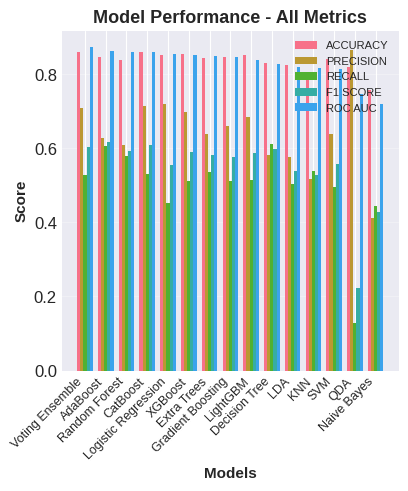

In [142]:
# Model Comparison - All Metrics
ax1 = plt.subplot(3, 4, 1)
metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']
x_pos = np.arange(len(results_df_sorted))
width = 0.15

for i, metric in enumerate(metrics):
    ax1.bar(x_pos + i*width, results_df_sorted[metric], width, 
            label=metric.replace('_', ' ').upper())

ax1.set_xlabel('Models', fontweight='bold', fontsize=11)
ax1.set_ylabel('Score', fontweight='bold', fontsize=11)
ax1.set_title('Model Performance - All Metrics', fontsize=13, fontweight='bold')
ax1.set_xticks(x_pos + width * 2)
ax1.set_xticklabels(results_df_sorted.index, rotation=45, ha='right', fontsize=9)
ax1.legend(fontsize=8)
ax1.grid(axis='y', alpha=0.3)
plt.show()

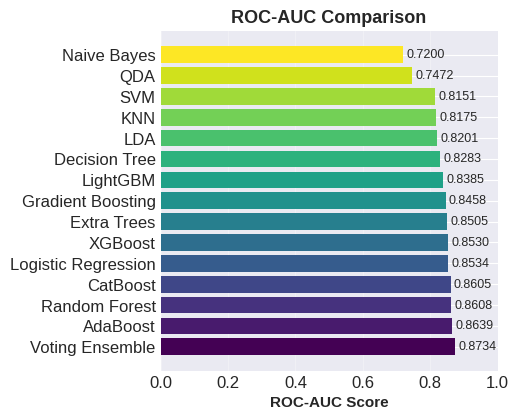

In [143]:
# ROC-AUC Comparison
ax2 = plt.subplot(3, 4, 2)
colors = plt.cm.viridis(np.linspace(0, 1, len(results_df_sorted)))
bars = ax2.barh(results_df_sorted.index, results_df_sorted['roc_auc'], color=colors)
ax2.set_xlabel('ROC-AUC Score', fontweight='bold', fontsize=11)
ax2.set_title('ROC-AUC Comparison', fontsize=13, fontweight='bold')
ax2.set_xlim(0, 1)
for i, (v, bar) in enumerate(zip(results_df_sorted['roc_auc'], bars)):
    ax2.text(v + 0.01, i, f'{v:.4f}', va='center', fontsize=9)
ax2.grid(axis='x', alpha=0.3)
plt.show()

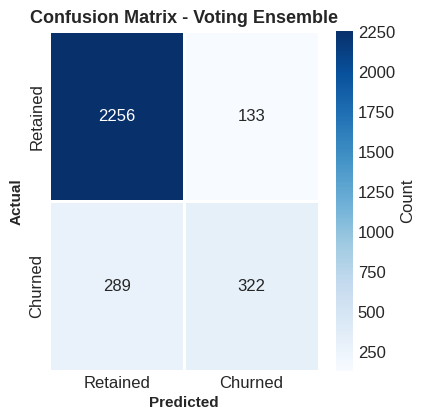

In [144]:
# Confusion Matrix Heatmap
ax3 = plt.subplot(3, 4, 3)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax3, 
            cbar_kws={'label': 'Count'}, linewidths=1)
ax3.set_xlabel('Predicted', fontweight='bold', fontsize=11)
ax3.set_ylabel('Actual', fontweight='bold', fontsize=11)
ax3.set_title(f'Confusion Matrix - {best_model_name}', fontsize=13, fontweight='bold')
ax3.set_xticklabels(['Retained', 'Churned'])
ax3.set_yticklabels(['Retained', 'Churned'])
plt.show()

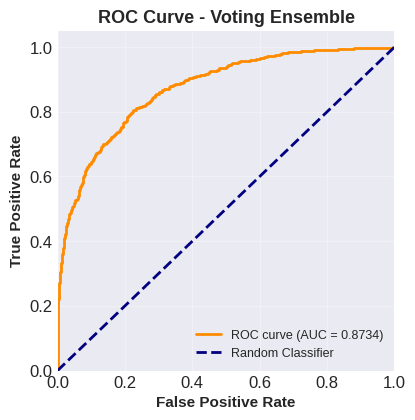

In [145]:
# ROC Curve
ax4 = plt.subplot(3, 4, 4)
fpr, tpr, _ = roc_curve(y_test, best_pred_proba)
roc_auc_val = auc(fpr, tpr)
ax4.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_val:.4f})')
ax4.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
ax4.set_xlim([0.0, 1.0])
ax4.set_ylim([0.0, 1.05])
ax4.set_xlabel('False Positive Rate', fontweight='bold', fontsize=11)
ax4.set_ylabel('True Positive Rate', fontweight='bold', fontsize=11)
ax4.set_title(f'ROC Curve - {best_model_name}', fontsize=13, fontweight='bold')
ax4.legend(loc="lower right", fontsize=9)
ax4.grid(alpha=0.3)
plt.show()

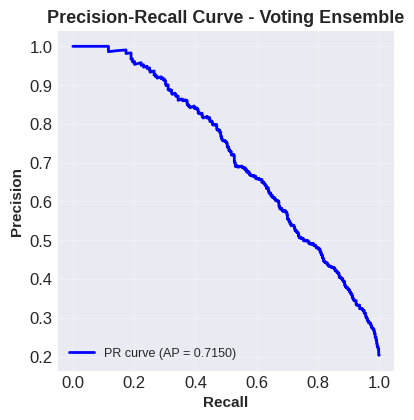

In [146]:
# Precision-Recall Curve
ax5 = plt.subplot(3, 4, 5)
precision_curve, recall_curve, _ = precision_recall_curve(y_test, best_pred_proba)
avg_precision = average_precision_score(y_test, best_pred_proba)
ax5.plot(recall_curve, precision_curve, color='blue', lw=2, 
         label=f'PR curve (AP = {avg_precision:.4f})')
ax5.set_xlabel('Recall', fontweight='bold', fontsize=11)
ax5.set_ylabel('Precision', fontweight='bold', fontsize=11)
ax5.set_title(f'Precision-Recall Curve - {best_model_name}', fontsize=13, fontweight='bold')
ax5.legend(loc="lower left", fontsize=9)
ax5.grid(alpha=0.3)
plt.show()

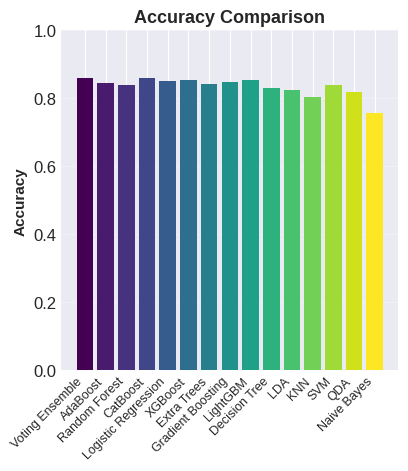

In [147]:
# Accuracy Comparison
ax7 = plt.subplot(3, 4, 7)
ax7.bar(results_df_sorted.index, results_df_sorted['accuracy'], color=colors)
ax7.set_ylabel('Accuracy', fontweight='bold', fontsize=11)
ax7.set_title('Accuracy Comparison', fontsize=13, fontweight='bold')
ax7.set_xticklabels(results_df_sorted.index, rotation=45, ha='right', fontsize=9)
ax7.set_ylim(0, 1)
ax7.grid(axis='y', alpha=0.3)
plt.show()

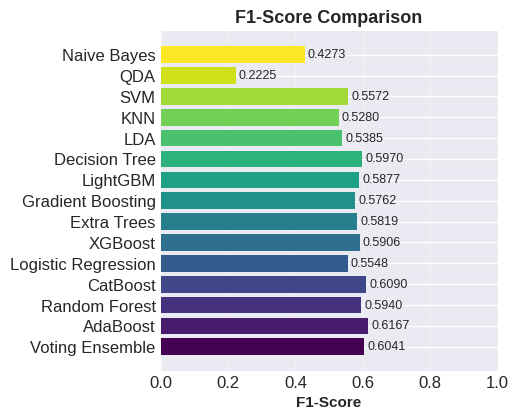

In [148]:
# F1-Score Comparison
ax8 = plt.subplot(3, 4, 8)
ax8.barh(results_df_sorted.index, results_df_sorted['f1_score'], color=colors)
ax8.set_xlabel('F1-Score', fontweight='bold', fontsize=11)
ax8.set_title('F1-Score Comparison', fontsize=13, fontweight='bold')
ax8.set_xlim(0, 1)
for i, v in enumerate(results_df_sorted['f1_score']):
    ax8.text(v + 0.01, i, f'{v:.4f}', va='center', fontsize=9)
ax8.grid(axis='x', alpha=0.3)
plt.show()

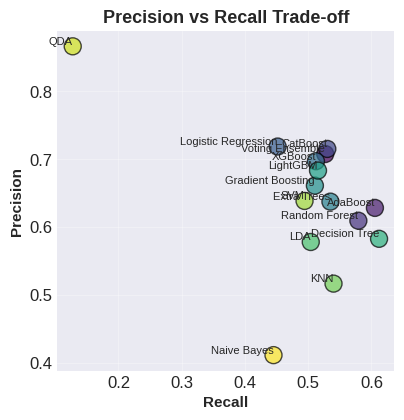

In [149]:
# Precision vs Recall Scatter
ax9 = plt.subplot(3, 4, 9)
precision_scores = results_df_sorted['precision'].values
recall_scores = results_df_sorted['recall'].values
ax9.scatter(recall_scores, precision_scores, s=150, c=colors, alpha=0.7, edgecolors='black')
for i, model in enumerate(results_df_sorted.index):
    ax9.annotate(model, (recall_scores[i], precision_scores[i]), 
                fontsize=8, ha='right', va='bottom')
ax9.set_xlabel('Recall', fontweight='bold', fontsize=11)
ax9.set_ylabel('Precision', fontweight='bold', fontsize=11)
ax9.set_title('Precision vs Recall Trade-off', fontsize=13, fontweight='bold')
ax9.grid(alpha=0.3)
plt.show()

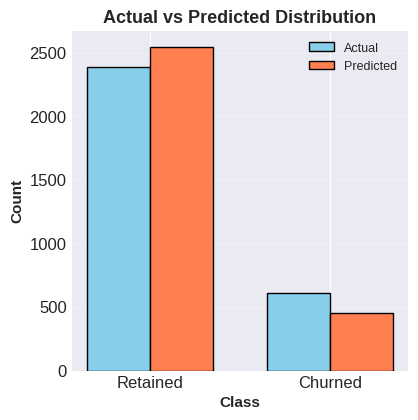

In [150]:
# Prediction Distribution
ax10 = plt.subplot(3, 4, 10)
pred_dist = pd.Series(best_pred).value_counts().sort_index()
actual_dist = pd.Series(y_test).value_counts().sort_index()
x = np.arange(2)
width = 0.35
ax10.bar(x - width/2, actual_dist.values, width, label='Actual', color='skyblue', edgecolor='black')
ax10.bar(x + width/2, pred_dist.values, width, label='Predicted', color='coral', edgecolor='black')
ax10.set_xlabel('Class', fontweight='bold', fontsize=11)
ax10.set_ylabel('Count', fontweight='bold', fontsize=11)
ax10.set_title('Actual vs Predicted Distribution', fontsize=13, fontweight='bold')
ax10.set_xticks(x)
ax10.set_xticklabels(['Retained', 'Churned'])
ax10.legend(fontsize=9)
ax10.grid(axis='y', alpha=0.3)
plt.show()

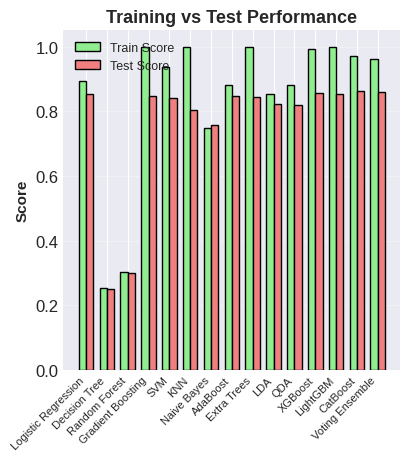

In [151]:
# Model Training Score vs Test Score
ax11 = plt.subplot(3, 4, 11)
train_scores = []
test_scores = []
model_names_for_plot = []

for model_name, model in trained_models.items():
    try:
        if model_name in ['Decision Tree', 'Random Forest']:
            train_score = model.score(X_train, y_train)
            test_score = model.score(X_test, y_test)
        elif model_name == 'Voting Ensemble':
            train_score = model.score(X_train_scaled, y_train_balanced)
            test_score = model.score(X_test_scaled, y_test)
        else:
            train_score = model.score(X_train_scaled, y_train_balanced)
            test_score = model.score(X_test_scaled, y_test)
        
        train_scores.append(train_score)
        test_scores.append(test_score)
        model_names_for_plot.append(model_name)
    except:
        pass

x_pos = np.arange(len(model_names_for_plot))
width = 0.35
ax11.bar(x_pos - width/2, train_scores, width, label='Train Score', color='lightgreen', edgecolor='black')
ax11.bar(x_pos + width/2, test_scores, width, label='Test Score', color='lightcoral', edgecolor='black')
ax11.set_ylabel('Score', fontweight='bold', fontsize=11)
ax11.set_title('Training vs Test Performance', fontsize=13, fontweight='bold')
ax11.set_xticks(x_pos)
ax11.set_xticklabels(model_names_for_plot, rotation=45, ha='right', fontsize=8)
ax11.legend(fontsize=9)
ax11.grid(axis='y', alpha=0.3)
plt.show()

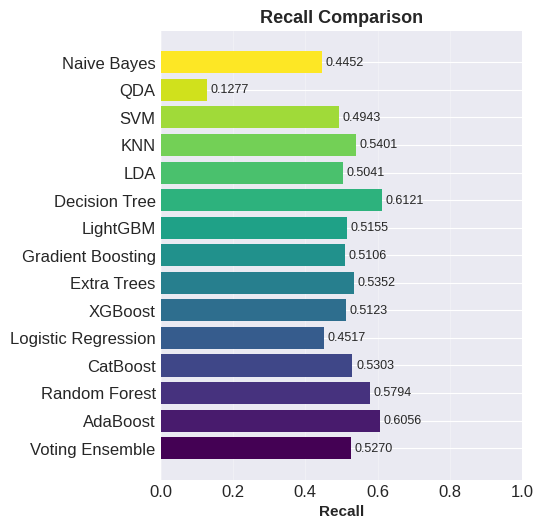

In [152]:
# Recall Comparison
ax12 = plt.subplot(3, 4, 12)
ax12.barh(results_df_sorted.index, results_df_sorted['recall'], color=colors)
ax12.set_xlabel('Recall', fontweight='bold', fontsize=11)
ax12.set_title('Recall Comparison', fontsize=13, fontweight='bold')
ax12.set_xlim(0, 1)
for i, v in enumerate(results_df_sorted['recall']):
    ax12.text(v + 0.01, i, f'{v:.4f}', va='center', fontsize=9)
ax12.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('model_evaluation_comprehensive.png', dpi=300, bbox_inches='tight')
plt.show()

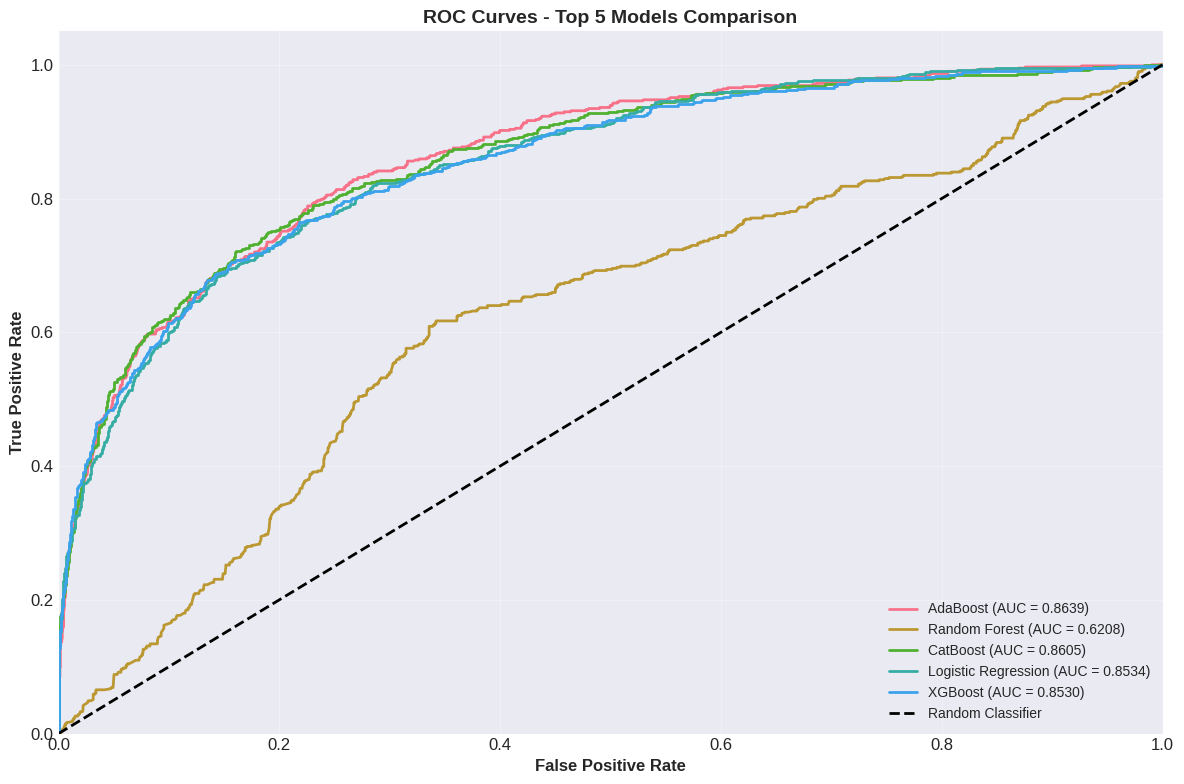

In [153]:
# ROC Curves for Top 5 Models
fig2, ax = plt.subplots(figsize=(12, 8))

for i, (model_name, _) in enumerate(top_models):
    if model_name == 'Voting Ensemble':
        y_pred_proba = voting_pred_proba
    elif model_name in ['Decision Tree', 'Random Forest']:
        y_pred_proba = trained_models[model_name].predict_proba(X_test)[:, 1]
    else:
        y_pred_proba = trained_models[model_name].predict_proba(X_test_scaled)[:, 1]
    
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.4f})')

ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax.set_title('ROC Curves - Top 5 Models Comparison', fontsize=14, fontweight='bold')
ax.legend(loc="lower right", fontsize=10)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('roc_curves_top_models.png', dpi=300, bbox_inches='tight')
plt.show()

### ***Saving Results***

In [154]:
# Save model comparison results
results_df_sorted.to_csv('model_comparison_results.csv')

In [155]:
# Save detailed results summary
with open('model_results_summary.txt', 'w') as f:
    f.write("CUSTOMER CHURN PREDICTION - MODEL RESULTS SUMMARY\n")
    
    f.write("DATASET INFORMATION\n")
    f.write(f"Total Samples: {len(df)}\n")
    f.write(f"Training Samples: {len(X_train)}\n")
    f.write(f"Test Samples: {len(X_test)}\n")
    f.write(f"Number of Features: {X.shape[1]}\n")
    f.write(f"Churn Rate: {y.mean()*100:.2f}%\n\n")
    
    f.write("MODEL PERFORMANCE SUMMARY\n")
    f.write(results_df_sorted.to_string())
    f.write("\n\n")
    
    f.write("BEST MODEL\n")
    f.write(f"Model: {best_model_name}\n")
    f.write(f"Accuracy: {best_metrics['accuracy']:.4f}\n")
    f.write(f"Precision: {best_metrics['precision']:.4f}\n")
    f.write(f"Recall: {best_metrics['recall']:.4f}\n")
    f.write(f"F1-Score: {best_metrics['f1_score']:.4f}\n")
    f.write(f"ROC-AUC: {best_metrics['roc_auc']:.4f}\n\n")
    
    f.write("CLASSIFICATION REPORT\n")
    f.write(classification_report(y_test, best_pred, target_names=['Retained', 'Churned']))
    
    f.write("CONFUSION MATRIX\n")
    f.write(str(cm) + "\n")

## ***Streamlit***

In [156]:
# Saving best model
try:
    with open('best_model.pkl', 'wb') as f:
        pickle.dump(best_model, f)
    print("\nBest model saved as 'best_model.pkl'")
except Exception as e:
    print(f"\nError saving best model: {e}")

# Save scaler
try:
    with open('scaler.pkl', 'wb') as f:
        pickle.dump(scaler, f)
    print("Feature scaler saved as 'scaler.pkl'")
except Exception as e:
    print(f"Error saving scaler: {e}")


Best model saved as 'best_model.pkl'
Feature scaler saved as 'scaler.pkl'
Error saving label encoders: name 'label_encoders' is not defined
